In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import timeit
from time import sleep
import cv2.aruco as aruco
import math
from IPython.display import display, clear_output

import math, sys, os
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from plotter import *
from kalman import *
from motion import *
from timer import *
from global_utils import *
from vision_utils import *
from local_utils import *

In [2]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [3]:
#sets the light off to avoid disturbance with vision
leds_bottom_left = [0, 0, 0]
leds_bottom_right = [0, 0, 0]

In [4]:
%%run_python

state = 1

@onevent
def move(speed_left, speed_right):
    global motor_left_target, motor_right_target, state
    if state == 1 :
        motor_left_target = speed_left
        motor_right_target = speed_right
    
@onevent 
def button_center():
    global state, motor_left_target, motor_right_target
    state = 0
    motor_left_target = 0
    motor_right_target = 0

In [5]:
def send_command():
    """
    Sends a new command to Thymio every time it is called.
    """
    # case the command is to go forward we correct the input with difference between left and right wheel
    if command[step][0] == command[step][1] and command[step][0] != 0:
        send_event("move", command[step][0] + 2, command[step][1] - 2)
        
    # case we want to turn or to stop
    else :
        send_event("move", command[step][0], command[step][1])
        
@tdmclient.notebook.sync_var
def get_speed():
    """
    gets the speed of the robot
    """
    return motor_left_speed, motor_right_speed
        
@tdmclient.notebook.sync_var
def get_proximity():
    """
    gets the proximity sensor values
    """
    return prox_horizontal

In [6]:
def kalman_call():
    """
    updates the estimated states of the robot and sends the command to the robot
    This function is called every Ts seconds by a timer
    """
    global step, x_est, P_est, camera_pos, cam_OK, command_finish, command 
    
    if step < len(command) :
        #retrieves the command that was applied Ts seconds ago
        speed_left = command[step][0]
        speed_right = command[step][1]
        
        #gets the right matrix corresponding to the command :
        #Thymio goes forward
        if speed_left == speed_right :
            A = A_F

        #Thymio is rotating
        else :
            A = A_R
            
        #measures the speed of the robot
        meas_speed_left,  meas_speed_right = get_speed()
        
        #get the last measured position by the camera
        meas_pos = camera_pos
            

        #computes the estimated states
        new_x_est, new_P_est = kalman_filter(meas_pos, meas_speed_left, meas_speed_right, x_est, P_est, A, cam_OK)

        x_est = new_x_est
        P_est = new_P_est
        
        step += 1
        
        if step < len(command) :
            send_command()
    else :
        #allow to know when we can input a new command in local avoidance mode
        if local_mode :
            command_finish = True
           

In [7]:
def mode_control():
    """
    Function called in timer every 0.05 second, that allow to switch the state of the robot between different modes
    depending on its behaviour and/or environment.
    """
    global local_mode, x_est, correction_mode, optimal_path, command, step, final_grid
    
    MIN_WALL_THRESHOLD = 2000  # min threshold to detect a wall or not
    
    #allows to know there is a global obstacle near us
    obstacle = check_obstacles(final_grid, x_est)
    
    #enters local avoidance mode if we detect an obstacle that is not global and if we were not already in local avoidance mode
    if max(get_proximity()) > MIN_WALL_THRESHOLD and not local_mode and not obstacle:      
        local_mode = True
        correction_mode = False
        local_avoidance(optimal_path)

    #exits local avoidance when we are far enough from the last obstacle thanks to a final correction
    elif local_mode and correction_mode and step >= 10 :
        local_mode = False
        
    #enters correction mode to correct the direction of Thymio with respect to the global path only if we were not already correcting it.
    elif not correction_mode:
        correction_mode = True
        correction() 
     
    #exits correction mode when we reached the end of correction command or when 1 second passed
    elif correction_mode and (step >= 10 or step >= len(command)) :
        correction_mode = False

In [8]:
def correction() :
    """
    Corrects the direction of Thymio every time it is used.
    """
    global optimal_path, command, x_est, step
    
    #it removes the first node of the node list every time we reach the next one closer than 3 cm
    if (np.linalg.norm(optimal_path[1][1] - np.squeeze(x_est[:2].transpose())) < 30) and len(optimal_path) > 2:
        optimal_path = optimal_path[1:]
        
    #computes the angle and the distance of thymio with respect to the optimal path
    angle, distance = calibrate_path(np.squeeze(x_est[:3].transpose()), optimal_path[1][1])

    #computes the new command :
    if step >= len(command):
        last_command = [0, 0]

    else :
        last_command = command[step]

    command = [last_command]

    step = 0

    if angle > 0:
        command += turn_left(angle)
    else :
        command += turn_right(angle)

    command += move_forward(distance) + [[0, 0]]

    #stops the robot when it is less than 2cm from the goal
    if len(optimal_path) == 2 and distance <= 20 :
        command =  [last_command] + [[0, 0]]
    

In [9]:
def local_avoidance(full_path) :
    """
    Obstacle avoidance: it handles the obstacle avoidance routine
    :return: a boolean to know if the A* path is crossed
    """

    """
   Parameters
   :param full_path: list of the two coordinates of the optimal path before and after actual thymio's position
   """
    
    #Initialization
    global_path = False
    
    #time to sleep before another iteration in the while loop
    T = 0.1
    
    # global variables
    global command, step, command_finish, x_est, final_grid

    # Define constants
    MIN_WALL_THRESHOLD = 2000  # min threshold to detect a wall or not
    # Distances
    DISTANCE_ADVANCE = 30 # constant step to move forward in mm
    # Angles of rotation
    conv = math.pi/180 # conversion deg to rad
    ANGLE_AVOIDANCE = 13*conv
    ANGLE_ADJUSTMENT = 10*conv

    
    # We want to make the robot avoid the obstacles following its left wall. Hence, when an obstacle is detected
    # first it starts to rotate left in order to be almost parallel to the obstacle. It corrects its position
    # until all the sensor values are smaller the the minimum threshold. 
    
    command_finish = True # We need this boolean variable in order to check that the previous command
                          # is finished. Only when this happens, a new command can be ordered to the robot.
    sleep(T) # we need sleep in order to avoid Thymio's overload
    sensor_values = get_proximity()  # load the sensors values
    # Rotate left until the obstacle is not detected anymore
    
    while (sensor_values[0] > MIN_WALL_THRESHOLD or sensor_values[1] > MIN_WALL_THRESHOLD or sensor_values[2] > MIN_WALL_THRESHOLD or sensor_values[3] > MIN_WALL_THRESHOLD or sensor_values[4] > MIN_WALL_THRESHOLD):
        # if the previous command is finished we can order a new one
        if command_finish :
            command_finish = False # first it is set to False: only when the command will be executed it will be True
            # Initialization of the command
            if step >= len(command): # previous command finished: initialize to 0
                last_command = [0, 0]
            else : # initialize at the previous command
                last_command = command[step]
            command = [last_command]
            step = 0 # step initialization
            # Add the new command
            command += turn_left(ANGLE_AVOIDANCE) + [[0, 0]] # rotate left
        
        sleep(T) # we need sleep in order to avoid Thymio's overload
        sensor_values = get_proximity() # update the sensors values

            
    # Now that the robot is positioned correctly to avoid the obstacle, it has to advance and rotate right 
    # until it finds global path
    sleep(T) # we need sleep in order to avoid Thymio's overload
    sensor_values = get_proximity()
    while True :
        # always check global path
        global_path = check_returned_to_global_path(full_path, x_est)
        
        if global_path:  # if the full path is reached, return -> leave the local avoidance
            return global_path
        
        if command_finish : # if the previous command is finished we can order a new one
            command_finish = False
            if step >= len(command):
                last_command = [0, 0]
            else :
                last_command = command[step]
            command = [last_command]
            step = 0
            command += move_forward(DISTANCE_ADVANCE) + turn_right(ANGLE_ADJUSTMENT)  + [[0, 0]] #move forward and rotate right
        sleep(T) # we need sleep in order to avoid Thymio's overload
        sensor_values = get_proximity() # update sensors values
        # If the robot rotates right too much, we need to correct its direction and rotate left until the last right sensor
        # does not detect the obstacle anymore
        while (sensor_values[4] > MIN_WALL_THRESHOLD):
            if command_finish : # if the previous command is finished we can order a new one
                command_finish = False
                if step >= len(command):
                    last_command = [0, 0]
                else :
                    last_command = command[step]
                command = [last_command]
                step = 0
                command += turn_left(ANGLE_ADJUSTMENT) + [[0, 0]] # rotate left
            sleep(T) # we need sleep in order to avoid Thymio's overload
            sensor_values = get_proximity()

    return global_path

## Dynamic plotting in main loop

In [10]:
thymio_icon = cv2.imread('imgs/Thymio.jpg')
thymio_icon = cv2.cvtColor(thymio_icon, cv2.COLOR_RGB2BGR)

def vision_update():
    """
    function called every 0.05 seconds to update the position of thymio measured by the camera
    """
    global cap, frame, cam_OK, img_out, camera_pos,x_est,\
           Thymio_center, Thymio_dir, Thymio_target,\
           warpedimg_clean_annotated, warpedimg_annotated
    
    ret, frame_tmp = cap.read()
    if ret:
        frame = cv2.cvtColor(frame_tmp, cv2.COLOR_BGR2RGB)

    cam_OK, Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp = localisation_cam(frame)
    thymio_filtered = x_est
    
    if cam_OK:
        Thymio_center, Thymio_dir, warpedimg = Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp
        warpedimg_annotated = overlay_vis_graph([int(Thymio_start[0]),int(Thymio_start[1])],[int(thymio_filtered[0][0]),int(thymio_filtered[1][0])], [int(Thymio_target[0]),int(Thymio_target[1])], obs_corners, optimal_path, warpedimg)
        camera_pos = np.array(Thymio_center + [np.deg2rad(Thymio_dir)]).reshape(3,1)
    warpedimg_clean = merge_img(img_out, rotate_image(thymio_icon,np.rad2deg(thymio_filtered[2][0])), int(thymio_filtered[0][0])-120, int(thymio_filtered[0][0])+120, int(thymio_filtered[1][0])-120, int(thymio_filtered[1][0])+120)[:,:,0:3]
    warpedimg_clean_annotated = overlay_vis_graph([int(Thymio_start[0]),int(Thymio_start[1])],[int(thymio_filtered[0][0]),int(thymio_filtered[1][0])], [int(Thymio_target[0]),int(Thymio_target[1])], obs_corners, optimal_path, warpedimg_clean)

Unchecked ExtSlice(dims=[Slice(lower=None, upper=None, step=None), Slice(lower=None, upper=None, step=None), Slice(lower=Constant(value=0, kind=None), upper=Constant(value=3, kind=None), step=None)])


In [11]:
#setup camera
cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_EXPOSURE, -4)  #adjust this to avoid reflection from A4 paper

True

In [12]:
#warm up of camera
for i in range(20):
    ret, frame = cap.read()
    sleep(0.2)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

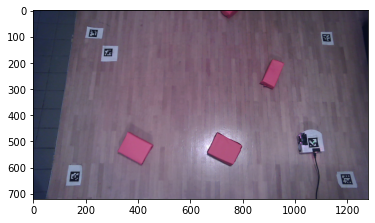

In [13]:
plt.imshow(frame)

In [14]:
cam_OK, Thymio_start, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, img_out = localisation_cam_all(frame)
print(cam_OK)

True


In [15]:
#Computing the optimal path with A* algorithm
cam_OK, Thymio_start, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, img_out = localisation_cam_all(frame)

discretized_path, optimal_path = do_global_navigation(obs_corners, Thymio_start + [np.deg2rad(Thymio_dir)], Thymio_target + [0.0])

#commands that allow thymio to from start to end if it needed zero corrections
global_command = calc_commands(discretized_path)

#final occupancy_grid of the obstacles
final_grid = obstacles_mask 

# first plot
Thymio_center = Thymio_start
cam_OK, Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp = localisation_cam(frame)
Thymio_center, Thymio_dir, warpedimg = Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp
warpedimg_clean = merge_img(img_out, rotate_image(thymio_icon,Thymio_dir), int(Thymio_center[0])-120, int(Thymio_center[0])+120, int(Thymio_center[1])-120, int(Thymio_center[1])+120)[:,:,0:3]
warpedimg_clean_annotated = overlay_vis_graph([int(Thymio_start[0]),int(Thymio_start[1])],[int(Thymio_center[0]),int(Thymio_center[1])], [int(Thymio_target[0]),int(Thymio_target[1])], obs_corners, optimal_path, warpedimg_clean)
warpedimg_annotated = overlay_vis_graph([int(Thymio_start[0]),int(Thymio_start[1])],[int(Thymio_center[0]),int(Thymio_center[1])], [int(Thymio_target[0]),int(Thymio_target[1])], obs_corners, optimal_path, warpedimg)
camera_pos = np.array(Thymio_center + [np.deg2rad(Thymio_dir)]).reshape(3,1)

#initial unknown state :
x0 = 0
y0 = 0
theta0 = 0
x_dot0 = 0 
y_dot0 = 0
theta_dot0 = 0 

x_est = np.array([[x0], [y0], [theta0], [x_dot0], [y_dot0], [theta_dot0]])

#initial high covariance matrix
P_est = 1000 * np.diag(np.ones(6))

Unchecked ExtSlice(dims=[Slice(lower=None, upper=None, step=None), Slice(lower=None, upper=None, step=None), Slice(lower=Constant(value=0, kind=None), upper=Constant(value=3, kind=None), step=None)])


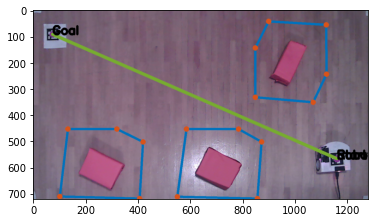

In [16]:
plt.imshow(warpedimg_annotated)

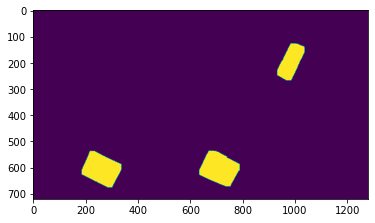

In [17]:
plt.imshow(final_grid)

In [18]:
optimal_path

[[1, array([ 566.25, 1161.25])], [18, array([92.75, 74.25])]]

In [19]:
#start vision update
rt1 = RepeatedTimer(0.05, vision_update)

#booleans that allow to know in which mode the robot is
local_mode = False
correction_mode = False
command_finish = False

step = 0
command = global_command + [[0, 0]]

#sends the first command
send_command()

#start Kalman
rt2 = RepeatedTimer(Ts, kalman_call)

#start mode control
rt3 = RepeatedTimerMode(0.05, mode_control)

In [20]:
#continuous plots in the main thread

%matplotlib qt
fig = plt.figure(figsize=(6, 6)) 
gs = GridSpec(6, 6, figure=fig)
ax1 = fig.add_subplot(gs[0:2, 4:6])
ax2 = fig.add_subplot(gs[2:4, 4:6])
ax3 = fig.add_subplot(gs[4:6, 4:6])
ax4 = fig.add_subplot(gs[0:3, 0:4])
ax5 = fig.add_subplot(gs[3:6, 0:4])
ax4.set_title("Robot Pose on estimated map")
ax5.set_title("Robot Pose on videos")
plt.tight_layout()

while(1):
    ax4.cla()
    ax4.imshow(warpedimg_clean_annotated)
    ax5.cla()
    ax5.imshow(warpedimg_annotated)
    plt.pause(0.001)
    clear_output(wait=True)
    plot(ax1, ax2, ax3, x_est, P_est, fig)
    print(f'localmode: {local_mode},correction_mode:{correction_mode}')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_20368/2422750013.py", line 22, in <module>
    plot(ax1, ax2, ax3, x_est, P_est, fig)
  File "D:\Academy\MICRO-452 Basics of Mobile Robotics\thymio_project\src\plotter.py", line 37, in plot
    fig.canvas.draw()
  File "C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py", line 406, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\artist.py", line 74, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\artist.py", line 51, in draw_wrapper
    return draw(artist, renderer, *args, **kwargs)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\

TypeError: object of type 'NoneType' has no len()

In [22]:
#stops all the timers at the end of mission
rt1.stop()
rt2.stop()
rt3.stop()